In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import least_squares as lsq
import random
random.seed(4321)
np.random.seed(1234)

In [2]:
PolRel = pd.read_excel("Seshat_PolityRelationData.xlsx")
Data = pd.read_csv("Seshat Data.csv")
Parameters_and_Times = np.loadtxt("Parameters_and_Times.txt")
RelTimeDF = pd.read_csv("RelTime_TimeSeries_SPC1.csv", index_col = 0)
RelTimeCCDF = pd.read_csv("RelTime_TimeSeries_CC.csv")
Parameters = Parameters_and_Times[:4]
Times = Parameters_and_Times[4:]
T = 5000

In [3]:
def f(x, a, b, c, d):
    # the logistic function in its most general shape, scaled by T=5000
    return a / (1. + np.exp(-c * (x - d))) + b

In [4]:
del RelTimeCCDF["Unnamed: 0"]

In [5]:
set(Data["NGA"]).issubset(set(PolRel["NGA"]))

True

In [6]:
# Discard superfluous NGAs
SubsetNGA = np.array(PolRel["NGA"].isin(set(Data["NGA"])))
PolRel = PolRel.iloc[SubsetNGA]


In [7]:
PolRel.head(50)

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
21,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland II,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [8]:
for i in list(set(PolRel["Dupl"])):
    print(i,sum(PolRel["Dupl"] == i))

n 596
y 103


In [9]:
# relationship to preceding (quasi)polity

for v in list(set(PolRel["Variable"])):
    print(v, sum(PolRel["Variable"]==v))

# Logical for Variable is the relationship
VR = PolRel["Variable"] == "relationship to preceding (quasi)polity"

Previous = PolRel.loc[np.logical_not(VR)]
Relationships = PolRel.loc[VR]

relationship to preceding (quasi)polity 335
succeeding (quasi)polity 364


In [10]:
Previous.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN


In [11]:
Relationships.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
23,Cahokia,USMisMu,Cahokia - Late Woodland II,450.0,600.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [12]:
for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )
                

suspected unknown 2
elite migration 40
contination 1
replacement 1
Continuation 1
not applicable 2
Continuity 9
continunity 4
continuity 228
continuation 7
population migration 13
indigenous revolt 1
cultural assimilation 25
vassalage 1


In [13]:
# Ever

Relationships["Value.From"].replace("Continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continunity", "continuity", inplace = True)
Relationships["Value.From"].replace("contination", "continuity", inplace = True)
Relationships["Value.From"].replace("Continuity", "continuity", inplace = True)

                
for val in list(set(Relationships["Value.From"])):
    if val != "continuity":
        Relationships["Value.From"].replace(val, "discontinuity", inplace = True)

for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )    

continuity 250
discontinuity 85


C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [14]:
CleanRel = pd.concat((Previous,Relationships), sort=False).sort_index()

In [15]:
CleanRel.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN


In [16]:
TimeZero = pd.read_csv("TimeZero.csv")
TimeZero.head()

,Unnamed: 0,Konya Plain,Ghanaian Coast,Cuzco,Middle Yellow River Valley,Yemeni Coastal Plain,Deccan,Latium,Upper Egypt,Susiana,Iceland,Orkhon Valley,Sogdiana,Paris Basin,Niger Inland Delta,Cambodian Basin,Kachi Plain,Central Java,Kansai
0,T0,-2000,1800,1400,-1800,400,-300,-700,-3100,-3700,1300,500,-500,-200,1000,300,-2500,800,400


In [17]:

# Again Discard superfluous NGAs
SubsetNGA_2 = np.array(Relationships["NGA"].isin(set(TimeZero.columns)))
Relationships = Relationships.iloc[SubsetNGA_2]

set(Relationships["NGA"]).issubset( set(TimeZero.columns))


True

In [18]:
Relationships["Polity.End.Scaled"] = 0

# iterate over all rows in the DF
for i in range(Relationships.shape[0]):
    n = Relationships["NGA"].iloc[i]
    
    # for this NGA: read its Time_Zero from the TimeZero.csv
    T_zero = TimeZero[n]
    # Shift the time accordingly
    Relationships["Polity.End.Scaled"].iloc[i] = Relationships["Polity.End"].iloc[i] - T_zero
    

C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [19]:
from scipy.stats import gaussian_kde
KDE = gaussian_kde(Relationships["Polity.End.Scaled"])
time_range = np.arange(-6000,6000,10)
KDE_t = KDE(time_range)

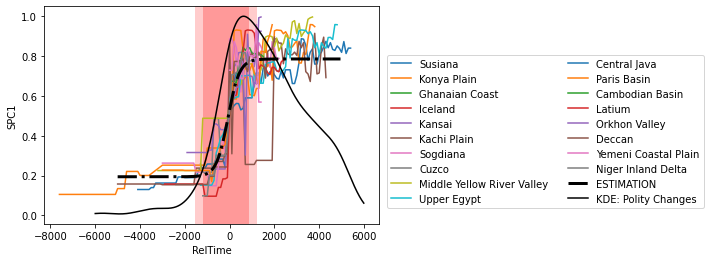

In [20]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE: Polity Changes")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)


plt.show()

## Normalise the Number of Polity Changes

Divide it by the number of existing polities at RelTime T, because if there are only few polities at an early time, we would also only expect few possible polity changes.

In [21]:
T_min, T_max = min(RelTimeDF["RelTime"]), max(RelTimeDF["RelTime"])

In [22]:
NumberPol = pd.DataFrame(columns=["RelTime", "NumberPol"])
for t in np.arange(T_min, T_max+100, 100):
    #print(t)
    #print(sum(RelTimeDF["RelTime"]==t))
    NumberPol = pd.concat([NumberPol,
                         pd.DataFrame({"RelTime": [t],
                                      "NumberPol": [sum(RelTimeDF["RelTime"]==t)]})])
NumberPol

,RelTime,NumberPol
0,-7600,1
0,-7500,1
0,-7400,1
0,-7300,1
0,-7200,1
...,...,...
0,5000,1
0,5100,1
0,5200,1
0,5300,1


In [23]:
NumberPol["NumberPol"].loc[NumberPol["RelTime"]==1000]

0    13
Name: NumberPol, dtype: object

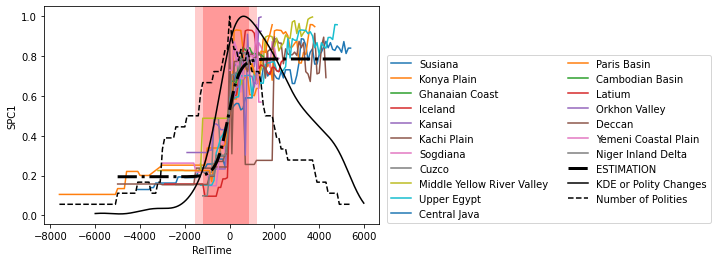

In [24]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE or Polity Changes")

plt.plot(NumberPol["RelTime"], NumberPol["NumberPol"]/np.max(NumberPol["NumberPol"]), "--", c="k",
        label="Number of Polities")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)

plt.show()

## Deal with the Continuity of Polities

In [25]:
 # this DF tells is, if a polity in an NGA is continuous or not
print(Relationships)
print(sorted(list(set(Relationships["NGA"])))) # only the long-lived ones remain

                      NGA    PolID               Longform.Name  Polity.Start  \
42        Cambodian Basin  KhFunaE                     Funan I         225.0   
44        Cambodian Basin  KhFunaL                    Funan II         540.0   
46        Cambodian Basin  KhChenl                      Chenla         550.0   
49        Cambodian Basin  KhAngkE                Early Angkor         802.0   
51        Cambodian Basin  KhAngkC            Classical Angkor        1100.0   
..                    ...      ...                         ...           ...   
830           Upper Egypt  TrOttm3           Ottoman Empire II        1517.0   
834           Upper Egypt  TrOttm4          Ottoman Empire III        1683.0   
858  Yemeni Coastal Plain  YeQasmi     Yemen - Qasimid Dynasty        1637.0   
861  Yemeni Coastal Plain  TrOttm4          Ottoman Empire III        1683.0   
862  Yemeni Coastal Plain  YeOttoL  Ottoman Empire Late Period        1873.0   

     Polity.End Dupl            Section

In [26]:
print(Relationships[["NGA", "Polity.End.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"].iloc[50:70])

             NGA  Polity.End.Scaled
580     Sogdiana              -50.0
587     Sogdiana              529.0
593     Sogdiana             1061.0
606     Sogdiana             1712.0
699      Susiana             1617.0
708      Susiana             2300.0
710      Susiana             2500.0
713      Susiana             2600.0
726      Susiana             3740.0
744      Susiana             4762.0
745      Susiana             4762.0
746      Susiana             4857.0
747      Susiana             4857.0
754      Susiana             5039.0
756      Susiana             5039.0
757      Susiana             5201.0
764      Susiana             5422.0
765      Susiana             5625.0
784  Upper Egypt             2353.0
788  Upper Egypt             2575.0


In [27]:
Breakpoints = Relationships[["NGA", "Polity.End.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"]
Breakpoints.columns = ["NGA", "RelTime"]
Breakpoints.head()

,NGA,RelTime
67,Central Java,718.0
138,Cuzco,-751.0
142,Cuzco,-401.0
145,Cuzco,-150.0
149,Cuzco,132.0


In [28]:
# Get the snippet that includes RelTime=0 and does not have any discontinuity
def Cutout(nga, df = RelTimeDF):
    
    
    Output = df.loc[df["NGA"]==nga]
    
    # if the nga has a discontinuous breakpoint, we need to cut out the central part of Output around 0
    if nga in set(Breakpoints["NGA"]):
        
        # get this nga's breakpoints
        BPs = Breakpoints.loc[Breakpoints["NGA"] == nga]
        
        
        # isolate the first breakpoint above zero
        # NOT exactly zero, because a breakpoint at zero means that up to RelTime 0, the polity has changed
        BP_positive = BPs.loc[BPs["RelTime"] > 0]
        
        if BP_positive.shape[0]>0: # is there any Breakpoint after 0?
            BP_end = min(BP_positive["RelTime"])
        else:
            BP_end = np.infty # else: latest possible year
        
        # Now need the beginning of the cutout-area, i.e. the last breakpoint before BP_end
        BP_rest = BPs.loc[BPs["RelTime"] < BP_end]
        
        
        if BP_rest.shape[0] > 0: # is there even a breakpoint before this?
            BP_start = max(BP_rest["RelTime"])
        else:
            BP_start = -np.inf # else: set the earliest possible time as beginning for the cutout
    
        print("BPs",BPs)
        print(BP_start,BP_end)
        
        Output = Output.loc[Output["RelTime"] > BP_start-1 ]
        Output = Output.loc[Output["RelTime"] < BP_end +1 ]
        
    return(Output)

In [29]:
## Test
Cutout_DF = pd.DataFrame(columns = RelTimeDF.columns)
Cutout_CCDF = pd.DataFrame(columns = RelTimeCCDF.columns)

for n in list(set(RelTimeDF["NGA"])):
    print(Cutout(n))
    Cutout_DF = pd.concat((Cutout_DF, Cutout(n)))
    Cutout_CCDF = pd.concat((Cutout_CCDF, Cutout(n, RelTimeCCDF)))

BPs          NGA  RelTime
699  Susiana   1617.0
708  Susiana   2300.0
710  Susiana   2500.0
713  Susiana   2600.0
726  Susiana   3740.0
744  Susiana   4762.0
745  Susiana   4762.0
746  Susiana   4857.0
747  Susiana   4857.0
754  Susiana   5039.0
756  Susiana   5039.0
757  Susiana   5201.0
764  Susiana   5422.0
765  Susiana   5625.0
-inf 1617.0
         NGA  RelTime      SPC1
372  Susiana    -4100  0.129737
373  Susiana    -4000  0.129737
374  Susiana    -3900  0.129737
375  Susiana    -3800  0.129737
376  Susiana    -3700  0.129737
377  Susiana    -3600  0.129737
378  Susiana    -3500  0.139350
379  Susiana    -3400  0.139350
380  Susiana    -3300  0.162183
381  Susiana    -3200  0.162183
382  Susiana    -3100  0.162183
383  Susiana    -3000  0.162183
384  Susiana    -2900  0.162183
385  Susiana    -2800  0.162183
386  Susiana    -2700  0.162183
387  Susiana    -2600  0.162183
388  Susiana    -2500  0.162183
389  Susiana    -2400  0.162183
390  Susiana    -2300  0.192817
391  Susiana  

BPs              NGA  RelTime
521  Paris Basin  -1800.0
533  Paris Basin   -125.0
540  Paris Basin    484.0
541  Paris Basin    484.0
542  Paris Basin    484.0
543  Paris Basin    484.0
544  Paris Basin    484.0
552  Paris Basin    743.0
-125.0 484.0
                 NGA  RelTime      SPC1
629  Cambodian Basin        0  0.673646
630  Cambodian Basin      100  0.673646
631  Cambodian Basin      200  0.673646
632  Cambodian Basin      300  0.664762
633  Cambodian Basin      400  0.753940
634  Cambodian Basin      500  0.783000
635  Cambodian Basin      600  0.844609
636  Cambodian Basin      700  0.828656
637  Cambodian Basin      800  0.840909
638  Cambodian Basin      900  0.840909
639  Cambodian Basin     1000  0.812885
640  Cambodian Basin     1100  0.812885
641  Cambodian Basin     1200  0.810691
642  Cambodian Basin     1300  0.806051
643  Cambodian Basin     1400  0.806733
644  Cambodian Basin     1500  0.797299
BPs         NGA  RelTime
375  Latium    984.0
384  Latium   1604.0
-i

In [30]:
Cutout_DF, Cutout_CCDF


(                    NGA RelTime      SPC1
 372             Susiana   -4100  0.129737
 373             Susiana   -4000  0.129737
 374             Susiana   -3900  0.129737
 375             Susiana   -3800  0.129737
 376             Susiana   -3700  0.129737
 ..                  ...     ...       ...
 623  Niger Inland Delta     300  0.718475
 624  Niger Inland Delta     400  0.720930
 625  Niger Inland Delta     500  0.767729
 626  Niger Inland Delta     600  0.816770
 627  Niger Inland Delta     700  0.816770
 
 [365 rows x 3 columns],
                     NGA RelTime      SPC1    PolPop   PolTerr    CapPop  \
 372             Susiana   -4100  0.129737  1.597045  1.844231  2.591618   
 373             Susiana   -4000  0.129737  1.597045  1.844231  2.591618   
 374             Susiana   -3900  0.129737  1.597045  1.844231  2.591618   
 375             Susiana   -3800  0.129737  1.597045  1.844231  2.591618   
 376             Susiana   -3700  0.129737  1.597045  1.844231  2.591618   
 

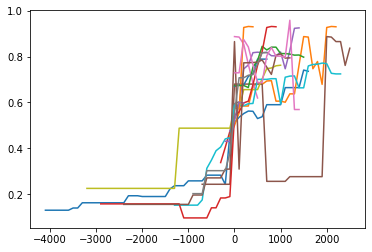

In [31]:
Cutout_DF
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"])
plt.show()

# Redo the RelTime Analysis with this Data?

## Fitting

In [32]:
X, y = Cutout_DF["RelTime"].to_numpy(), Cutout_DF["SPC1"].to_numpy()
T = 5000
X = np.array(list(X)) # for some reason, this transformation is necessary
X = X/T # normalisation of the data

def f(x, a, b, c, d):
    # the logistic function in its most general shape
    return a / (1. + np.exp(-c * (x - d))) + b

(a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, p0 = Parameters)

P0 = np.array((a_, b_, c_, d_))
print(P0)

[ 5.05526190e-01  2.04512960e-01  4.20835764e+01 -2.17749679e-02]


In [33]:
# comparison with full data:
Parameters

array([ 5.91641014e-01,  1.93784863e-01,  1.93749264e+01, -1.54321408e-02])

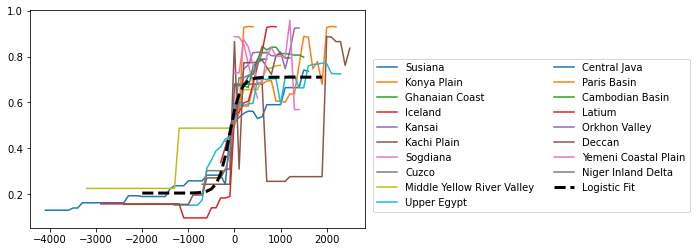

In [34]:
Cutout_DF
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"], label=n)

TimeRange = np.arange(-2000,2000,100)
New_Fit = f(TimeRange/T, a_, b_, c_, d_)
plt.plot(TimeRange, New_Fit, "--",label="Logistic Fit", c="k", linewidth = 3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.show()

## Out-of-Sample prediction
To evaluate quality of the fit.

In [35]:
L = len(Cutout_DF["RelTime"].to_numpy())
def RhoSq(y_hat, y_true): # like in Turchin's original PCA paper
    y_mean = np.mean(y_true)
    return(1 - sum((y_hat-y_true)**2)/sum((y_mean-y_true)**2)  )

In [36]:
C_list = list()
RhoSqList = list()
n_split = 1000
for i in range(1000):
    
    Selection = np.random.choice(np.arange(L), size = int(L/2), replace = False)
    
    X_train = X[Selection]
    y_train = y[Selection]
    
    test_indx = np.ones(len(X), bool)
    test_indx[Selection]=0
    y_test = y[test_indx]
    X_test = X[test_indx]
    
    (a1_, b1_, c1_, d1_), _ = opt.curve_fit(f, X_train, y_train,
                                            p0 = Parameters) # initial guess to ensure c > 0
    #print((a1_, b1_, c1_, d1_))
    C_list.append(c1_)
    RhoSqList.append(RhoSq( f(X_test, a1_, b1_, c1_, d1_), y_test))
    

In [37]:
print(np.mean(RhoSqList), np.median(RhoSqList), np.std(RhoSqList))

0.7493942620998564 0.7526733233109054 0.0312575313346315


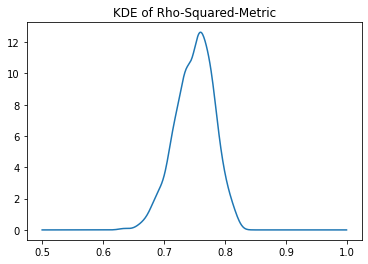

In [56]:
plt.plot(np.arange(0.5,1,0.001),
    gaussian_kde(RhoSqList)(np.arange(0.5,1,0.001)))
plt.title("KDE of Rho-Squared-Metric")
plt.show()

## Bootstrapping

First round of bootstrap: estimate many parameter values for a and b and the standard deviations for a, b a+b. This allows to compute the thresholds of the plateaus.

In [39]:
np.random.seed(1234)
random.seed(1234)
nBT = 1000 # how many Bootstraps
negCcount = 0

Params = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters
NGA_list = list(set(Cutout_DF["NGA"]))


for i in range(nBT):
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection:
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0

    Params = pd.concat([Params,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_]})])
    if c_ < 0:
        print(NGA_selection)
        negCcount +=1
        for N in NGA_selection:
            DF = Data_RT[Data_RT["NGA"] == N]
            plt.plot(DF["RelTime"]/T,    # ALSO normalised
            DF["SPC1"], label=N)
            plt.plot(x_show, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # FOR FULL DATA
            plt.plot(x_show, f(x_show, a_, b_, c_, d_), "-.",c="r", linewidth = 3)

        plt.show()
        
    print(a_, b_, c_, d_)
    print("-----------------")
print(Params.round(2))

0.5652877266695637 0.1788781595680195 45.311099929557244 -0.017807405506071152
-----------------
0.5649266360429697 0.20995950721746437 12.258605673967569 -0.05322665350592595
-----------------
0.4722007470521979 0.19865739305130886 45.40389161405092 -0.025951540086613135
-----------------
0.5419941681513207 0.20848110077127435 19.65285211953681 -0.032626362973991185
-----------------
0.4193799352329784 0.28085872766243297 52.825828132847214 -0.01722701880873838
-----------------
0.48046509925608744 0.2066156828923352 34.506423828581745 -0.02615941262476742
-----------------
0.5104374226135658 0.20063786350575225 26.521920734257804 -0.03287004572043133
-----------------
0.540720741440619 0.16601774338893666 53.32518899607759 -0.01795076428284234
-----------------
0.6094069709212843 0.16731241877553346 29.710493743093338 -0.02327715402507227
-----------------
0.42786909608552454 0.2342227744931586 176.58030175096542 -0.015184831270862611
-----------------
0.5655733700873742 0.1965103795

C:\Users\Tobias\AppData\Local\Temp/ipykernel_18084/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.42840443905589637 0.22355469147301682 864.0994100783278 -0.018909441199270353
-----------------
0.5154656946118841 0.1906375852323515 23.41790557868147 -0.03581998507773499
-----------------
0.4842417040282108 0.19423933391961862 74.13538613959811 -0.018967910998572445
-----------------
0.5119285446092057 0.19776659216677958 37.578973049281636 -0.02452293499380993
-----------------
0.45564606446834555 0.2039062569821412 120.68072017799376 -0.015174572101104837
-----------------
0.4764461549723129 0.2038604624040674 59.254507585866676 -0.020697587049176135
-----------------
0.5073689262087592 0.2063530885513503 48.41396097829727 -0.024032045683937176
-----------------
0.586667881651701 0.19014953978912352 26.131583955355474 -0.0163479291592744
-----------------
0.5235330532329983 0.19103243012262955 55.792352207984855 -0.017493988647832144
-----------------
0.5679711194278693 0.16728804873754655 26.520380595370483 -0.029507845613425204
-----------------
0.5572643764734784 0.1885512636

0.5897565819135567 0.19529712668205623 29.930363215130978 -0.011369495128815764
-----------------
0.5372381974002786 0.18967067183403147 54.57142083665933 -0.020438369512922248
-----------------
0.4737893668412973 0.21602581281248162 41.24615142430605 -0.02058385347625751
-----------------
0.39029393842081495 0.2852665431233011 138.51822071404558 -0.013086073257193366
-----------------
0.4495404402245234 0.209182208199283 39.13017540675573 -0.025778976434210985
-----------------
0.5039210234882223 0.20759410421380708 27.465300459547358 -0.023324545195437415
-----------------
0.5173514842247089 0.1980164960363317 45.9548228577183 -0.014881738242879665
-----------------
0.6025180907375067 0.19638716884030996 31.880176310530242 -0.011162194745417749
-----------------
0.48731897975963206 0.17809658693844435 88.52618679082107 -0.01554717286376887
-----------------
0.41776718885265446 0.26685545839640507 48.508579262533715 -0.020966005695036236
-----------------
0.5099544415552507 0.21219371

0.5654543652006361 0.19826425255212923 16.02836378630645 -0.027101777133161475
-----------------
0.5274485358376542 0.18711640075018954 40.34730895167921 -0.02768473296401295
-----------------
0.574397318449085 0.22350117020404253 18.922438472537795 -0.02326675648966524
-----------------
0.6109207224867319 0.16104618085940578 31.796950595697382 -0.015148277572764247
-----------------
0.4952441582171542 0.19931559245276878 54.831660603046785 -0.022666837421257986
-----------------
0.5030872629427624 0.18907062892332555 36.75637289625905 -0.01816659799424387
-----------------
0.5592046754133025 0.17234048869776325 35.96987079023364 -0.02198556958073187
-----------------
0.5389682224638938 0.18955932303807235 41.25754291593283 -0.01603755829065992
-----------------
0.5280858409927711 0.20203520073574813 33.017729995465785 -0.020473219895143842
-----------------
0.4999364961062076 0.22444745996661095 45.97369527400409 -0.01694200677553533
-----------------
0.5698466057421231 0.181740918581

0.4678611460274838 0.20190371141408786 65.0360223448082 -0.018158319936078998
-----------------
0.5498181914422723 0.21401582472466124 41.991227078824075 -0.014575965335271099
-----------------
0.5543902176116561 0.2137050920405288 26.331394499211086 -0.017171229929905055
-----------------
0.5581443404284561 0.18923317122706548 22.648745357923715 -0.029099466227810677
-----------------
0.49993727785669634 0.1902928213018027 44.123057244492685 -0.026493848598603008
-----------------
0.5034042130212062 0.19634105464017249 64.44124506946089 -0.021560362164770825
-----------------
0.4476773176649957 0.21329026371592835 44.31604962182531 -0.025842283965499445
-----------------
0.5153276251275212 0.2017333878315883 46.83764888958964 -0.01998226202371307
-----------------
0.48224305203450707 0.19320235481388412 47.72176719294512 -0.02192509874558444
-----------------
0.4827111006478676 0.21837522378483584 43.51951852620009 -0.026479583760480166
-----------------
0.45773289261042577 0.22003574

0.5039304059011702 0.2256254311098252 40.36984269097239 -0.017235704078733684
-----------------
0.585910367090213 0.1985345754071404 23.10522965094194 -0.018772707272524836
-----------------
0.5424333889196089 0.19119940199867663 27.384051890384246 -0.029319435644503136
-----------------
0.505242469751885 0.18448046635057486 33.02379283586643 -0.03592349489620646
-----------------
0.47616985307443427 0.22917740646775384 33.46529078362906 -0.027453734770833103
-----------------
0.5281157377514413 0.18647040622604316 44.89737235529706 -0.020008483799221044
-----------------
0.5164502440339308 0.20721283323559678 46.98450642087878 -0.017202424875949734
-----------------
0.5803666751286498 0.1867151805396683 26.571710643207155 -0.02052907252711173
-----------------
0.4186680377712265 0.26454662670551726 105.09366661566425 -0.017205887141914934
-----------------
0.5510449988888426 0.1902611030746825 28.940667352263443 -0.027711633636976072
-----------------
0.46775525933932893 0.21934901380

0.48870171657177275 0.18233268396677652 46.04423091909457 -0.024988206704595863
-----------------
0.5038798472077417 0.174390535755807 49.25004650727994 -0.018942629263682825
-----------------
0.5273577102954975 0.1819766790142561 36.4901951292394 -0.028004929892806778
-----------------
0.4469520733243123 0.21528391620256987 51.419068835558235 -0.02292835816481136
-----------------
0.5027707710785624 0.1885003799584275 63.12306187074753 -0.01770275259191979
-----------------
0.4191380103577789 0.2386359191229253 895.5499987960369 -0.019010644896695884
-----------------
0.49688032080419253 0.21458706169923972 40.49815299006733 -0.01777537983305785
-----------------
0.6054927633050861 0.1687090570528211 28.221410306073732 -0.026534853256520267
-----------------
0.5199883484142143 0.19168635373502121 63.181565939534906 -0.014502492747900414
-----------------
0.5011117699749661 0.20145467670516065 51.44825617952075 -0.023837982332817
-----------------
0.44815753701772165 0.2038702126931398

0.4590127845446943 0.23982759455078556 38.18061970192181 -0.02079806922604493
-----------------
0.5106341008856534 0.21583313112075853 28.97796129051168 -0.022754771413674685
-----------------
0.5340323678213595 0.20233787476614284 22.867740722990128 -0.030779480303714666
-----------------
0.6069487937212172 0.15408670077743897 26.661624683232677 -0.020755768188301278
-----------------
0.48026659415582945 0.23890978944827407 51.89991365962324 -0.018705395663197052
-----------------
0.5779097761177773 0.1813678184942867 33.98885693502245 -0.023029077943792563
-----------------
0.5336621316422312 0.18025010356275267 56.70397745793924 -0.019367135570129607
-----------------
0.5314037659012667 0.18867256784112696 28.72085067375671 -0.02324180675328824
-----------------
0.5343709055297984 0.18683390859425675 44.66914350070418 -0.022513428973225745
-----------------
0.5021857173894423 0.22192510473411953 22.320161334185258 -0.031151882340850333
-----------------
0.5909944596350711 0.19282945

0.5787156749711655 0.19834849756313483 24.63723406120418 -0.01951584659396829
-----------------
0.4274615868104693 0.2089709914988181 68.10880851474457 -0.0195574031833805
-----------------
0.6001586419680964 0.1603586718581698 30.1044537321517 -0.013987010029890633
-----------------
0.5189744015679083 0.1881191802450307 58.30171407038088 -0.02028233710223601
-----------------
0.5614207642433023 0.20601273002506898 31.99975445559723 -0.018600326889791827
-----------------
0.5657198475989322 0.19249849819125595 21.771427823897596 -0.023600417612276044
-----------------
0.5296030357644234 0.2680312200874129 33.71272794631291 -0.007681576011839473
-----------------
0.36709406253253607 0.29286379596296386 120.8761933947569 -0.014603962178714253
-----------------
0.448030718559438 0.24856045873763175 62.539521240452565 -0.0217084396969485
-----------------
0.6124131381013527 0.16064938370141565 33.503564199491976 -0.015757698476954424
-----------------
0.5450676505101442 0.20018951882303662

0.5578665696815202 0.19453619142589554 23.622065252424616 -0.027621550953932747
-----------------
0.5088825408307586 0.1982603116075363 41.82340351117958 -0.026851323409514242
-----------------
0.48757154507420286 0.22131467708310407 34.58384048017394 -0.018883217915060212
-----------------
0.4922638144363109 0.23382643626727015 30.296984812097065 -0.018567495187390516
-----------------
0.5155699430020563 0.2538438033184761 26.021286961096376 -0.012996660805186988
-----------------
0.5584502207011056 0.18298669882937418 43.30338122433385 -0.012381564106226005
-----------------
0.5986543990250559 0.2016276470954334 11.424933795741746 -0.03163600361806926
-----------------
0.38878261128947655 0.2550490325560086 135.7794078597423 -0.014393876973981404
-----------------
0.4458747603234 0.23738483057234014 103.154342112689 -0.014306083914363487
-----------------
0.5163179081252991 0.1902266758388392 25.20681276774342 -0.03228979133882215
-----------------
0.5173463958201929 0.23241501237734

0.46204698782397063 0.22325970801273334 68.08934049669972 -0.017484696322741463
-----------------
0.5159688479312399 0.2102584201680736 56.32207396535517 -0.017780526539727406
-----------------
0.47928779409067523 0.20451932272852189 33.66658742918913 -0.0316816814439296
-----------------
0.5155795052076917 0.19954044810064284 33.74856772319333 -0.020007507415797862
-----------------
0.4676719296936037 0.21305892804837614 36.48082924135109 -0.03200970231397688
-----------------
0.5414568343000724 0.20708311564612883 24.584987957217386 -0.027361725547868865
-----------------
0.5864007026861457 0.20453092271224696 12.458304918910873 -0.03899466936377593
-----------------
0.5185680826385604 0.17986761843245358 60.0971490898099 -0.020610157734762265
-----------------
0.46853941854102515 0.23794648799714224 42.55313872039319 -0.022865004152353787
-----------------
0.4099869908926624 0.24036407156281644 74.21533081574144 -0.018959920106403808
-----------------
0.5188661911441306 0.2006130208

0.6076463766137935 0.15208005886267328 24.94365422350759 -0.027975787485734392
-----------------
0.5176313034049993 0.1604769690898901 58.093957319283234 -0.01873644604363817
-----------------
0.5389554239448517 0.17835097634522543 30.802267756939177 -0.02818010048280144
-----------------
0.5609573989269154 0.20448586563296614 25.113577289721132 -0.021117207078887593
-----------------
0.5740102828279354 0.18206397581751657 27.557721414047442 -0.016954463994916392
-----------------
0.47175849684439514 0.2337524803810709 47.0736327031283 -0.02392140592751658
-----------------
0.47090736192429317 0.2156390468653886 51.430956914512926 -0.02279671243986591
-----------------
0.4649652801047147 0.20422958727209012 36.10435276948332 -0.0343106611755034
-----------------
0.4912452882823781 0.172621143822804 59.27305434354334 -0.01969121138746314
-----------------
0.46207615875461916 0.23095050969703582 33.07028617953015 -0.028041802613841888
-----------------
0.550929230009957 0.184706610632533

In [40]:
print(negCcount)

0


In [41]:
Params

,a,b,c,d
0,0.565288,0.178878,45.311100,-0.017807
0,0.564927,0.209960,12.258606,-0.053227
0,0.472201,0.198657,45.403892,-0.025952
0,0.541994,0.208481,19.652852,-0.032626
0,0.419380,0.280859,52.825828,-0.017227
...,...,...,...,...
0,0.414619,0.292613,80.558732,-0.011624
0,0.589854,0.168738,35.183847,-0.021161
0,0.494914,0.224057,32.233290,-0.028723
0,0.491978,0.176686,226.212334,-0.015697


50% centred quantiles 0.4720901845002472 0.5564181023956494
90% centred quantiles 0.41266184437120285 0.5993757927863834


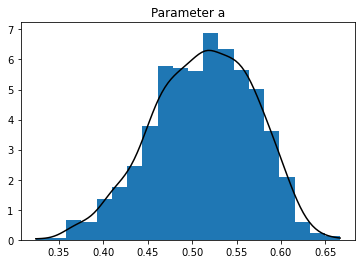

50% centred quantiles 0.1836347172823242 0.2185970274647738
90% centred quantiles 0.16311513596447277 0.2601197296054174


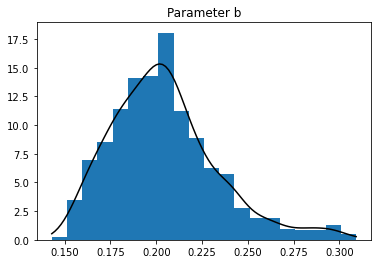

50% centred quantiles 29.146796624964466 57.881020373625596
90% centred quantiles 20.0048921218775 146.8297824483923


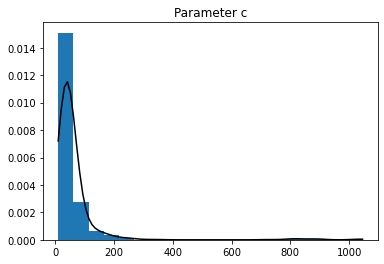

50% centred quantiles -0.02483412246982764 -0.01726059962792268
90% centred quantiles -0.03336885071492193 -0.013414579749620622


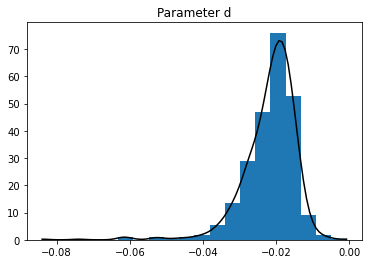

In [42]:
for P in Params.columns:
    
    
    Ps = Params[P]
    P_range = np.linspace(min(Ps), max(Ps),100)
    KDE = gaussian_kde(Ps)(P_range)
    
    print("50% centred quantiles", np.quantile(Ps, 0.25), 
          np.quantile(Ps, 0.75))
    print("90% centred quantiles", np.quantile(Ps, 0.05), 
          np.quantile(Ps, 0.95))
    plt.hist(Ps,bins=20, density= True)
    plt.plot(P_range, KDE, c="k")
    plt.title("Parameter "+str(P))
    plt.show()

### In more detail for c

In [43]:
np.quantile(Params["c"], 0.25), np.quantile(Params["c"], 0.75)

(29.146796624964466, 57.881020373625596)

[1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.16227766e+04 3.98107171e+04 5.01187234e+04
 6.30957344e+04 7.94328235e+04]


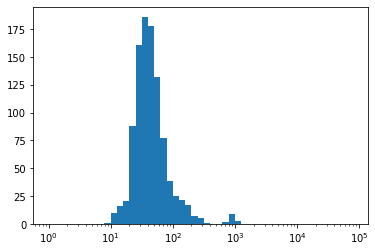

In [44]:
bins = 10**(np.arange(0,5,0.1))
print(bins)
plt.xscale('log')
plt.hist(Params["c"],bins=bins) 


plt.show()

### Analysis of the Curve

When does f(x) = y_est actually change? 
f(-infinity) = b and f(infinity) = a + b. We can now calculate the standard deviations of b and a+b via the bootstrap estimations and check when y_est exceeds b + sd(b) and reaches a+b - sd(a+b).

In [45]:
print(np.mean(Params["b"]), np.std(Params["b"]))
print(np.mean(Params["b"]+Params["a"]), np.std(Params["b"]+Params["a"]))

Thresh1 = np.mean(Params["b"]) + np.std(Params["b"])
Thresh2 = np.mean(Params["b"]+Params["a"]) - np.std(Params["b"]+Params["a"])
print(Thresh1, Thresh2)

def f1(x):
    # first threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh1)

T1 = opt.root(f1, -0.5)

def f2(x):
    # second threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh2)

T2 = opt.root(f2, 0.5)

0.20424693036574523 0.02914110065857104
0.7166869820142228 0.04134455715378595
0.23338803102431627 0.6753424248604368


C:\Users\Tobias\AppData\Local\Temp/ipykernel_18084/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


In [46]:
Timeframe = (T2["x"] -T1["x"])[0]
t_2, t_1 = T2["x"], T1["x"]
# scale this back to original time
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*Timeframe), "years.")

Most of the cultural evolution takes place in a time interval of  643.0 years.


## Bootstrapping the Time Interval

Now we can repeat this task, but 

-> Calculate the time thresholds T1/T2 for every single Bootstrapped Data and therefore calculate a time interval with standard deviation

In [47]:
def fBT1(x):
    # first threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh1)

def fBT2(x):
    # second threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh2)


In [48]:
np.random.seed(1234)
random.seed(1234)
nBT = 1000 # how many Bootstraps
Successes = 0

Params2 = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters

for i in range(nBT):
    
    # Select the random NGAs
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection: # combine them to a data frame
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0
    
    # Time Intervals
    T1 = opt.root(fBT1, t_1)
    T2 = opt.root(fBT2, t_2)
    
    # only add results, if opt.root is successful:
    if T1["success"] and T2["success"]:
        Successes += 1
        Params2 = pd.concat([Params2,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_], "T1":T1["x"], "T2":T2["x"]})])    
        print(a_, b_, c_, d_, T1, T2)
        print("-----------------")


0.5652877266695637 0.1788781595680195 45.311099929557244 -0.017807405506071152     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([1.56887281e-11])
       r: array([-2.23173478])
  status: 1
 success: True
       x: array([-0.06718941])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-3.68149955e-13])
       r: array([-2.73879497])
  status: 1
 success: True
       x: array([0.02580149])
-----------------
0.5649266360429697 0.20995950721746437 12.258605673967569 -0.05322665350592595     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-7.86770649e-12])
       r: array([-0.27529053])
  status: 1
 success: True
       x: array([-0.30940467])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.5576429e-13])
       r: array([-1.005248

C:\Users\Tobias\AppData\Local\Temp/ipykernel_18084/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.4680763206700491 0.21791643538276353 58.524745763724646 -0.023708306864039207     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.59854369e-11])
       r: array([-0.87554486])
  status: 1
 success: True
       x: array([-0.08139354])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([1.78101978e-12])
       r: array([-0.60912608])
  status: 1
 success: True
       x: array([0.04053843])
-----------------
0.6041549874271716 0.15774313580489865 26.938123826262213 -0.02038495119692779     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-1.37156952e-12])
       r: array([-1.78259194])
  status: 1
 success: True
       x: array([-0.09255078])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.4540924e-11])
       r: array(

0.46131602829555657 0.22401871402565632 50.09888733633277 -0.021757832236826403     fjac: array([[-1.]])
     fun: array([9.99200722e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.15772308e-10])
       r: array([-0.45986304])
  status: 1
 success: True
       x: array([-0.0991273])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.5620838e-13])
       r: array([-0.48976073])
  status: 1
 success: True
       x: array([0.05429911])
-----------------
0.5135691094939153 0.185216425857532 41.73782169696893 -0.019008692138913222     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([3.97154531e-13])
       r: array([-1.82199012])
  status: 1
 success: True
       x: array([-0.07335082])     fjac: array([[-1.]])
     fun: array([-1.88737914e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.62195488e-10])
       r: array([-0

0.5715560346669416 0.19572287093316154 21.423750433324784 -0.01926578494804438     fjac: array([[-1.]])
     fun: array([1.11022302e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.22539431e-10])
       r: array([-0.75375669])
  status: 1
 success: True
       x: array([-0.14302824])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.5576429e-13])
       r: array([-1.65280441])
  status: 1
 success: True
       x: array([0.05784001])
-----------------
0.54464101779863 0.18346136379025701 37.51596154395361 -0.018653376728087957     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([9.13658038e-13])
       r: array([-1.70134695])
  status: 1
 success: True
       x: array([-0.07978536])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([1.14847021e

0.5679711194278693 0.16728804873754655 26.520380595370483 -0.029507845613425204     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-6.83497703e-12])
       r: array([-1.54898513])
  status: 1
 success: True
       x: array([-0.10594622])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.25295346e-14])
       r: array([-1.42138561])
  status: 1
 success: True
       x: array([0.05109554])
-----------------
0.5572643764734784 0.18855126365427569 36.21305277247325 -0.018117504489867802     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-2.2276625e-12])
       r: array([-1.49303701])
  status: 1
 success: True
       x: array([-0.08538968])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([8.96500651e-11])
       r: array([-2.2293072

0.48101186842801547 0.2182523729928839 24.43597769810397 -0.03969963848726078     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-1.08349441e-12])
       r: array([-0.35821677])
  status: 1
 success: True
       x: array([-0.17993821])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([3.13719051e-11])
       r: array([-0.55548293])
  status: 1
 success: True
       x: array([0.08102766])
-----------------
0.5220457852880686 0.17614617264992238 37.717713655142596 -0.023914776587351437     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.14502852e-12])
       r: array([-1.92229637])
  status: 1
 success: True
       x: array([-0.07944121])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([4.01900735e-14])
       r: array([-0.8241104

0.5051997629381962 0.2113068023755927 26.536496537675266 -0.024205158522199642     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-3.16913162e-13])
       r: array([-0.5603475])
  status: 1
 success: True
       x: array([-0.14048027])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([3.08642001e-14])
       r: array([-1.00334631])
  status: 1
 success: True
       x: array([0.06708021])
-----------------
0.5401131332769722 0.17896517397923623 49.13149176785691 -0.022078243702242976     fjac: array([[-1.]])
     fun: array([-1.94289029e-15])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([3.74951709e-10])
       r: array([-2.40446363])
  status: 1
 success: True
       x: array([-0.06662782])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-6.91113833e-13])
       r: arra

0.5372381974002786 0.18967067183403147 54.57142083665933 -0.020438369512922248     fjac: array([[-1.]])
     fun: array([-2.66453526e-15])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-3.81886911e-10])
       r: array([-2.191567])
  status: 1
 success: True
       x: array([-0.06485392])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.33146835e-15])
       r: array([-2.54394982])
  status: 1
 success: True
       x: array([0.02065753])
-----------------
0.4737893668412973 0.21602581281248162 41.24615142430605 -0.02058385347625751     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-2.91064117e-11])
       r: array([-0.68988373])
  status: 1
 success: True
       x: array([-0.09984295])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.4810709e-11])
    

0.5704707407692787 0.2096870325637409 27.002950538792135 -0.012630916746473753     fjac: array([[-1.]])
     fun: array([1.38777878e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.11844098e-10])
       r: array([-0.61341138])
  status: 1
 success: True
       x: array([-0.12885935])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([7.32747196e-15])
       r: array([-2.3102947])
  status: 1
 success: True
       x: array([0.04259437])
-----------------
0.5604693858510681 0.19155443520951085 30.411771824251648 -0.02313099253907747     fjac: array([[-1.]])
     fun: array([2.49800181e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-8.64862626e-11])
       r: array([-1.17727718])
  status: 1
 success: True
       x: array([-0.10591151])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.56319402e-13])
    

0.539180824006808 0.17453669803682945 53.070011771345456 -0.019438500791616978     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.23207e-12])
       r: array([-2.78234105])
  status: 1
 success: True
       x: array([-0.05899865])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.56572541e-13])
       r: array([-1.89161821])
  status: 1
 success: True
       x: array([0.02896566])
-----------------
0.5088378045798525 0.19475317998231997 52.52337693289219 -0.017350732969221558     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-7.91459953e-11])
       r: array([-1.87515258])
  status: 1
 success: True
       x: array([-0.06492973])     fjac: array([[-1.]])
     fun: array([9.99200722e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.91166083e-10])
       r: array(

       x: array([0.0780916])
-----------------
0.5274485358376542 0.18711640075018954 40.34730895167921 -0.02768473296401295     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-1.87411198e-12])
       r: array([-1.70315422])
  status: 1
 success: True
       x: array([-0.08572345])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-5.32907052e-15])
       r: array([-1.46484235])
  status: 1
 success: True
       x: array([0.03481083])
-----------------
0.574397318449085 0.22350117020404253 18.922438472537795 -0.02326675648966524     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.97175609e-13])
       r: array([-0.18386335])
  status: 1
 success: True
       x: array([-0.23702104])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.62869718

       x: array([0.04840236])
-----------------
0.5896689035037652 0.16501441255670482 33.33718751081283 -0.016176757578889152     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([5.04812858e-12])
       r: array([-2.01508442])
  status: 1
 success: True
       x: array([-0.0771096])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-2.31148434e-12])
       r: array([-2.28911226])
  status: 1
 success: True
       x: array([0.03965579])
-----------------
0.5739166977352744 0.18611783219295497 28.79927181077384 -0.01783684060288858     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.40715217e-12])
       r: array([-1.24922126])
  status: 1
 success: True
       x: array([-0.10154206])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
   

0.5608577048350365 0.19076820357330448 21.04401122995346 -0.02048317627010486     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-3.38880868e-11])
       r: array([-0.82873808])
  status: 1
 success: True
       x: array([-0.13919224])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.75749432e-11])
       r: array([-1.38697022])
  status: 1
 success: True
       x: array([0.06737147])
-----------------
0.5708629569075881 0.20689084579217057 21.1999965554832 -0.02895133193311876     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-4.71859218e-11])
       r: array([-0.53566783])
  status: 1
 success: True
       x: array([-0.17152602])     fjac: array([[-1.]])
     fun: array([-2.10942375e-15])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([3.9976022

0.5696996868407449 0.2018099276724934 30.949421509948795 -0.011269120608103646     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.64303016e-11])
       r: array([-0.92315269])
  status: 1
 success: True
       x: array([-0.10289024])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 5
     qtf: array([2.38761233e-11])
       r: array([-2.47390696])
  status: 1
 success: True
       x: array([0.04023854])
-----------------
0.5412896302192318 0.17007639665317303 106.43125203604404 -0.013417358489020674     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([1.2330692e-12])
       r: array([-5.9501916])
  status: 1
 success: True
       x: array([-0.0324108])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.2873

       x: array([0.0541423])
-----------------
0.5449435226129884 0.17730231522333414 27.35388615748723 -0.03019919847697836     fjac: array([[-1.]])
     fun: array([2.49800181e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-9.98038319e-11])
       r: array([-1.37626938])
  status: 1
 success: True
       x: array([-0.10935397])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([6.75304257e-12])
       r: array([-1.17256396])
  status: 1
 success: True
       x: array([0.05617208])
-----------------
0.5579606669213946 0.1647366808106624 56.90521344245868 -0.017127118138595108     fjac: array([[-1.]])
     fun: array([-5.55111512e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.84347898e-10])
       r: array([-3.42593892])
  status: 1
 success: True
       x: array([-0.05163984])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
  

0.509245196391219 0.21616131479921485 56.41504853608765 -0.017500895484663243     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([3.61866093e-12])
       r: array([-0.93896987])
  status: 1
 success: True
       x: array([-0.07691864])     fjac: array([[-1.]])
     fun: array([5.55111512e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.55928936e-10])
       r: array([-2.54671128])
  status: 1
 success: True
       x: array([0.0217819])
-----------------
0.6237292292083875 0.15239130803430292 55.11639317765324 -0.014767549524828116     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([3.67372799e-12])
       r: array([-3.88452453])
  status: 1
 success: True
       x: array([-0.04928011])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-3.03179704e-12])
       r: array([-4.6570610

0.5184542903422922 0.21512593570060365 40.02660705266652 -0.0185081284322499     fjac: array([[-1.]])
     fun: array([3.88578059e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-8.3972107e-11])
       r: array([-0.70522528])
  status: 1
 success: True
       x: array([-0.10120724])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-9.14823772e-14])
       r: array([-2.06921429])
  status: 1
 success: True
       x: array([0.03313658])
-----------------
0.5761534053365478 0.18848032707215434 30.029319303062778 -0.015103722907198495     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-2.55351296e-14])
       r: array([-1.24343657])
  status: 1
 success: True
       x: array([-0.09737716])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([5.80723

0.5039304059011702 0.2256254311098252 40.36984269097239 -0.017235704078733684     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-3.02424752e-13])
       r: array([-0.30854775])
  status: 1
 success: True
       x: array([-0.12022339])     fjac: array([[-1.]])
     fun: array([1.11022302e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.75280021e-10])
       r: array([-1.95312858])
  status: 1
 success: True
       x: array([0.03517198])
-----------------
0.585910367090213 0.1985345754071404 23.10522965094194 -0.018772707272524836     fjac: array([[-1.]])
     fun: array([1.33226763e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.42595471e-10])
       r: array([-0.75739743])
  status: 1
 success: True
       x: array([-0.13825587])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([5.30242517e-13])
     

0.5851336833451275 0.18176237196544878 29.104738564221893 -0.015397369068926504     fjac: array([[-1.]])
     fun: array([9.99200722e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-2.58111921e-10])
       r: array([-1.36998838])
  status: 1
 success: True
       x: array([-0.0956405])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.52100554e-14])
       r: array([-2.24771769])
  status: 1
 success: True
       x: array([0.04248874])
-----------------
0.5650029570525986 0.1623904017455401 55.26548007619886 -0.01367688713334224     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-4.98420749e-11])
       r: array([-3.43066321])
  status: 1
 success: True
       x: array([-0.04877836])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-3.91464638e-12])
  

0.5844179036731931 0.1722933357674023 30.321019319363515 -0.030699217595246773     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.57682201e-12])
       r: array([-1.65879938])
  status: 1
 success: True
       x: array([-0.10153372])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-4.30211422e-13])
       r: array([-2.12367801])
  status: 1
 success: True
       x: array([0.02938107])
-----------------
0.5928100412280031 0.213922439070549 11.739288587158077 -0.03455543128069989     fjac: array([[-1.]])
     fun: array([3.88578059e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-8.38850933e-11])
       r: array([-0.22100969])
  status: 1
 success: True
       x: array([-0.32271925])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.42108547e-14])
       r: array(

0.615671701675541 0.1631159946818128 32.648823752135705 -0.017993486623166827     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.92068583e-14])
       r: array([-2.03243076])
  status: 1
 success: True
       x: array([-0.08075669])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-6.1284311e-14])
       r: array([-2.80990076])
  status: 1
 success: True
       x: array([0.03100442])
-----------------
0.5380027593570869 0.17902701388258382 34.74204925581633 -0.02601705498263758     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-2.55906407e-12])
       r: array([-1.69778405])
  status: 1
 success: True
       x: array([-0.08892921])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([6.60083099e-11])
       r: array([-

0.580999561378652 0.18538168956782686 27.963117248140524 -0.017433970688083538     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-5.24091881e-12])
       r: array([-1.23148825])
  status: 1
 success: True
       x: array([-0.10351792])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.60902411e-14])
       r: array([-2.14683002])
  status: 1
 success: True
       x: array([0.04275385])
-----------------
0.5181257147358957 0.17554904531608953 48.102762821111035 -0.02037126837070719     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([2.38864484e-13])
       r: array([-2.47163292])
  status: 1
 success: True
       x: array([-0.06349117])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.53705953e-12])
   

0.4880253861551228 0.22362684949712522 33.87381193467768 -0.02839846243382347     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.97262215e-14])
       r: array([-0.32403502])
  status: 1
 success: True
       x: array([-0.1432881])     fjac: array([[-1.]])
     fun: array([-5.55111512e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.42946655e-10])
       r: array([-1.13844539])
  status: 1
 success: True
       x: array([0.04602377])
-----------------
0.4988740546990874 0.19966545989530196 16.928163978920942 -0.04065109773822155     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-7.438411e-12])
       r: array([-0.53227286])
  status: 1
 success: True
       x: array([-0.19567061])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([1.15646381e-11])
       r: array([-0.37442519

0.5598222355818664 0.195331303054914 17.046261413656122 -0.022212140743387718     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.99062988e-13])
       r: array([-0.60462464])
  status: 1
 success: True
       x: array([-0.17580244])     fjac: array([[-1.]])
     fun: array([-1.88737914e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.94362876e-10])
       r: array([-1.16652926])
  status: 1
 success: True
       x: array([0.08303947])
-----------------
0.5267822931522793 0.1879522966295341 45.70116965364598 -0.025577311984982934     fjac: array([[-1.]])
     fun: array([-4.71844785e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([5.60331642e-10])
       r: array([-1.89738383])
  status: 1
 success: True
       x: array([-0.07722344])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.6645

0.5106341008856534 0.21583313112075853 28.97796129051168 -0.022754771413674685     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.49039114e-12])
       r: array([-0.49121681])
  status: 1
 success: True
       x: array([-0.13785385])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([6.81898982e-13])
       r: array([-1.33316544])
  status: 1
 success: True
       x: array([0.05302314])
-----------------
0.5340323678213595 0.20233787476614284 22.867740722990128 -0.030779480303714666     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-3.59823282e-13])
       r: array([-0.66876286])
  status: 1
 success: True
       x: array([-0.15256462])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.3759883e-12])
       r: array([-1.23608

0.4837852280948078 0.20553364382899303 34.45881781231569 -0.02932790967158463     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.41362486e-13])
       r: array([-0.90456627])
  status: 1
 success: True
       x: array([-0.1104494])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([4.99600361e-15])
       r: array([-0.46769811])
  status: 1
 success: True
       x: array([0.07267652])
-----------------
0.48474092116377865 0.23166872361274155 55.70918149836203 -0.01760093625103869     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-3.49720253e-15])
       r: array([-0.09544149])
  status: 1
 success: True
       x: array([-0.11880759])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([2.77555756e-15])
       r: array

0.5071831765935517 0.19467832247272268 53.96603803128413 -0.017612147595409546     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([4.87943019e-14])
       r: array([-1.9295703])
  status: 1
 success: True
       x: array([-0.06381508])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-8.77076189e-15])
       r: array([-1.35629988])
  status: 1
 success: True
       x: array([0.0360754])
-----------------
0.5698415593905025 0.20550321621152565 31.205930114191844 -0.018264207688448976     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-5.89750471e-13])
       r: array([-0.82759045])
  status: 1
 success: True
       x: array([-0.11334562])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.50990331e-14])
       r: arr

0.5152659754097384 0.19611787723072124 83.50832361404414 -0.019814981480253523     fjac: array([[-1.]])
     fun: array([3.24740235e-15])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([4.64292188e-10])
       r: array([-2.8872244])
  status: 1
 success: True
       x: array([-0.05036773])     fjac: array([[-1.]])
     fun: array([8.8817842e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-1.5609003e-10])
       r: array([-2.79925028])
  status: 1
 success: True
       x: array([0.01116996])
-----------------
0.5396442172382687 0.18368377909905098 51.66141843420297 -0.024947203861073873     fjac: array([[-1.]])
     fun: array([-8.32667268e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([4.77555773e-11])
       r: array([-2.33128772])
  status: 1
 success: True
       x: array([-0.0692393])     fjac: array([[-1.]])
     fun: array([1.11022302e-15])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-2.570500

0.5724912261173858 0.167818345310092 40.33302803488016 -0.020877865812474215     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.21869181e-12])
       r: array([-2.34172441])
  status: 1
 success: True
       x: array([-0.07158675])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.56182844e-11])
       r: array([-2.32296546])
  status: 1
 success: True
       x: array([0.03008936])
-----------------
0.5781405645647272 0.2080330429505257 19.555957389193726 -0.014138995203524055     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.28733413e-11])
       r: array([-0.47409596])
  status: 1
 success: True
       x: array([-0.17173776])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.74065232e-14])
       r: array([-1.75191135]

0.5664618701426251 0.1823350600944534 57.45578877287378 -0.01808505830665513     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([3.43044759e-11])
       r: array([-2.66891945])
  status: 1
 success: True
       x: array([-0.05832638])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.95399252e-14])
       r: array([-3.67311869])
  status: 1
 success: True
       x: array([0.01505099])
-----------------
0.5280237439327035 0.2194843608427831 27.46443407306772 -0.028295604645862022     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-6.89170943e-14])
       r: array([-0.3718016])
  status: 1
 success: True
       x: array([-0.1597494])     fjac: array([[-1.]])
     fun: array([-3.33066907e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-8.74075257e-11])
       r: array(

0.5602104240150078 0.16608363219399622 45.855247821467614 -0.02326905582468803     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([1.41259227e-11])
       r: array([-2.71547425])
  status: 1
 success: True
       x: array([-0.06669032])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.26374475e-13])
       r: array([-2.12390197])
  status: 1
 success: True
       x: array([0.02693413])
-----------------
0.6239981827577061 0.17773326058543834 32.96037791577179 -0.017472333154921305     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([8.55843174e-13])
       r: array([-1.6707905])
  status: 1
 success: True
       x: array([-0.08796782])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-6.77782275e-11])
       r: array(

0.5461764227095487 0.20328186999916886 18.64956826388969 -0.029899788545286424     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.67718617e-11])
       r: array([-0.53051855])
  status: 1
 success: True
       x: array([-0.18226327])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.14508411e-11])
       r: array([-1.19466211])
  status: 1
 success: True
       x: array([0.06937745])
-----------------
0.5975147502426933 0.20091716093389989 19.982549960005436 -0.013716848100555679     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.14630527e-13])
       r: array([-0.61359018])
  status: 1
 success: True
       x: array([-0.15666958])     fjac: array([[-1.]])
     fun: array([-5.55111512e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.86931257e-10])

0.5196242823627693 0.1914434115000068 35.70984729715122 -0.023124652370565806     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-8.47988346e-13])
       r: array([-1.37692923])
  status: 1
 success: True
       x: array([-0.09124564])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([5.39901457e-13])
       r: array([-1.18803396])
  status: 1
 success: True
       x: array([0.04985292])
-----------------
0.5784255736538316 0.16709535919044888 24.924884533313282 -0.032456811870998636     fjac: array([[-1.]])
     fun: array([1.38777878e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-3.03041814e-10])
       r: array([-1.46297125])
  status: 1
 success: True
       x: array([-0.11448346])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.38947759e-11])
   

       x: array([0.03221112])
-----------------
0.4975094301685073 0.20949085794724612 28.266680016224655 -0.03354605783135746     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-5.18529664e-13])
       r: array([-0.64304745])
  status: 1
 success: True
       x: array([-0.13920505])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([3.33066907e-15])
       r: array([-0.83792029])
  status: 1
 success: True
       x: array([0.06157939])
-----------------
0.5620215156561513 0.2017610229938037 25.346815596346264 -0.01909761577251674     fjac: array([[-1.]])
     fun: array([2.22044605e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-7.76083919e-11])
       r: array([-0.75653472])
  status: 1
 success: True
       x: array([-0.13033879])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
 

0.47372659684880175 0.2085742209906507 71.70913020487518 -0.018617115823051995     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([2.12857509e-13])
       r: array([-1.68617309])
  status: 1
 success: True
       x: array([-0.05899452])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-7.29416527e-14])
       r: array([-0.49165088])
  status: 1
 success: True
       x: array([0.04003489])
-----------------
0.5735222242357322 0.18030840927610162 22.29277812155399 -0.020969472107182374     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-9.42301792e-14])
       r: array([-1.07377828])
  status: 1
 success: True
       x: array([-0.12337423])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([5.1104676e-12])
       r: array

0.4676719296936037 0.21305892804837614 36.48082924135109 -0.03200970231397688     fjac: array([[-1.]])
     fun: array([2.22044605e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-6.78307133e-11])
       r: array([-0.70938769])
  status: 1
 success: True
       x: array([-0.11674658])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([3.40838469e-14])
       r: array([-0.19430959])
  status: 1
 success: True
       x: array([0.09002491])
-----------------
0.5414568343000724 0.20708311564612883 24.584987957217386 -0.027361725547868865     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-9.55208135e-13])
       r: array([-0.61528806])
  status: 1
 success: True
       x: array([-0.14835857])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([7.86668508e-11])
       r: arr

0.5416367569204087 0.19315245155755356 24.166891844889204 -0.022633847825731274     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-4.21471191e-12])
       r: array([-0.90013668])
  status: 1
 success: True
       x: array([-0.12701859])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([8.51883009e-11])
       r: array([-1.27896939])
  status: 1
 success: True
       x: array([0.06398286])
-----------------
0.49505945669317586 0.20905129417624424 69.05282381277422 -0.015788197980232475     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([8.33388913e-13])
       r: array([-1.59790766])
  status: 1
 success: True
       x: array([-0.05868698])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-8.92619312e-14])
       r: a

0.4829800907098281 0.2118444662342655 102.40638169330215 -0.016641920712062566     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([1.3524154e-11])
       r: array([-2.10779258])
  status: 1
 success: True
       x: array([-0.04656454])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([-6.09351458e-11])
       r: array([-1.9146267])
  status: 1
 success: True
       x: array([0.01430639])
-----------------
0.602461023939127 0.1732210427099698 29.82954582158472 -0.00921294747755928     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-5.89067406e-11])
       r: array([-1.61551195])
  status: 1
 success: True
       x: array([-0.08292123])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.49043017

0.5276927862448593 0.19112611487659037 47.64962755822231 -0.017368712907461274     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([1.75608417e-11])
       r: array([-1.85248768])
  status: 1
 success: True
       x: array([-0.06859997])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.52999835e-12])
       r: array([-1.90095661])
  status: 1
 success: True
       x: array([0.03321535])
-----------------
0.5489955464369745 0.21756611530813752 18.36901917087631 -0.032785750575953426     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.72000478e-11])
       r: array([-0.28225779])
  status: 1
 success: True
       x: array([-0.22427399])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.55351296e-15])


0.4949142985821618 0.224057301389378 32.23328995231892 -0.028722635630182302     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-5.25995913e-13])
       r: array([-0.2950899])
  status: 1
 success: True
       x: array([-0.15132998])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.02049488e-12])
       r: array([-1.28233868])
  status: 1
 success: True
       x: array([0.0437606])
-----------------
0.49803160851785255 0.21958999152387368 31.58945033667758 -0.02716640981848563     fjac: array([[-1.]])
     fun: array([1.38777878e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-3.68375608e-11])
       r: array([-0.42379795])
  status: 1
 success: True
       x: array([-0.13980024])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([7.54951657e-15])
       r: array([-1.22219549])

In [49]:
print(Successes)
print(Params2.round(2))

727
       a     b       c     d    T1    T2
0   0.57  0.18   45.31 -0.02 -0.07  0.03
0   0.56  0.21   12.26 -0.05 -0.31  0.07
0   0.54  0.21   19.65 -0.03 -0.19  0.06
0   0.48  0.21   34.51 -0.03 -0.11  0.08
0   0.51  0.20   26.52 -0.03 -0.13  0.06
..   ...   ...     ...   ...   ...   ...
0   0.62  0.17   30.26 -0.02 -0.09  0.03
0   0.47  0.21  124.67 -0.02 -0.04  0.02
0   0.59  0.17   35.18 -0.02 -0.08  0.03
0   0.49  0.22   32.23 -0.03 -0.15  0.04
0   0.50  0.22   31.59 -0.03 -0.14  0.05

[727 rows x 6 columns]


In [50]:
T2_scaled, T1_scaled = np.mean(Params2["T2"])*T, T*np.mean(Params2["T1"])

T1_start_scaled = T*np.mean(Params2["T1"]) - T*np.std(Params2["T1"])
T2_end_scaled = T*np.mean(Params2["T2"]) + T*np.std(Params2["T2"])

In [51]:
TimeframeBT = Params2["T2"]-Params2["T1"]
print(np.mean(TimeframeBT))

# times T for the transformation to years
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*np.mean(TimeframeBT)),
      u"\u00B1",np.round(T*np.std(TimeframeBT)), "years.")

0.15186834150200826
Most of the cultural evolution takes place in a time interval of  759.0 ± 330.0 years.


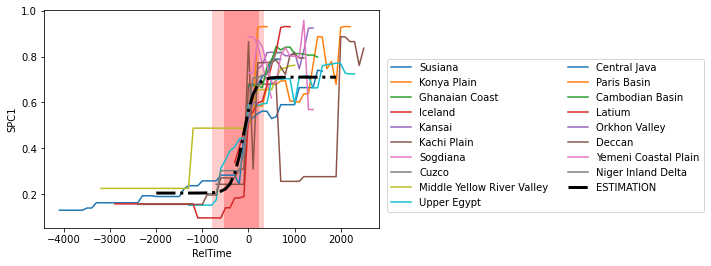

In [52]:
DF_Out_cutout = pd.DataFrame(columns=["NGA","RelTime","SPC1"])

for N in list(set(Cutout_DF["NGA"])):
    DF = Cutout_DF[Cutout_DF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    DF_Out_cutout = pd.concat((DF_Out_cutout, DF[["NGA", "RelTime", "SPC1"]]))
    #print(N)
    
plt.plot(TimeRange, New_Fit, "-.",label="ESTIMATION", c = "k", linewidth=3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.ylabel("SPC1")
plt.xlabel("RelTime")
plt.axvspan(T1_scaled, T2_scaled, facecolor='r', alpha=0.4)
plt.axvspan(T2_scaled, T2_end_scaled, facecolor='r', alpha=0.2)
plt.axvspan(T1_start_scaled, T1_scaled, facecolor='r', alpha=0.2)
plt.savefig("SPC1_Time_Interval_Cutouts")
plt.show()

In [53]:
Cutout_CCDF.index = np.arange(0,len(Cutout_CCDF["NGA"]))
Cutout_CCDF.to_csv("Cutouts_CC_with_Reltime.csv")